# Comparative Analysis of Traditional Machine Learning and Deep Learning for Pneumonia Detection in Chest X-Rays

## Abstract

This study presents a comprehensive comparison between traditional machine learning approaches and modern deep learning architectures for automated pneumonia detection using chest X-ray images. We evaluate classical feature extraction methods combined with standard classifiers against state-of-the-art convolutional neural networks and transfer learning models. The analysis provides insights into the strengths and limitations of each approach in medical image classification tasks.

**Dataset:** Chest X-Ray Images (Pneumonia) - Paul Mooney  
**Task:** Binary image classification (Normal vs Pneumonia)  
**Evaluation Metrics:** Accuracy, Precision, Recall, F1-Score, ROC-AUC  
**Dataset Size:** Approximately 5,863 X-ray images

---

## Section 1: Environment Setup and Configuration

In [22]:
# Verify GPU availability for deep learning experiments
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Device: {tf.test.gpu_device_name()}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Device: /device:GPU:0
GPU Available: True


In [23]:
import torch
torch.cuda.is_available()


True

## Section 2: Library Imports

In [54]:
# Core libraries
import os
import time
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm
from collections import Counter
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.regularizers import l2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Feature extraction
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import sobel

# Set random seeds
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("All libraries imported successfully")

All libraries imported successfully


## Section 3: Dataset Acquisition

In [25]:
downloadData = True

if downloadData:
    try:
        print("Installing kagglehub...")
        import subprocess
        subprocess.run(['pip', 'install', '-q', 'kagglehub'], check=True)

        import kagglehub

        print("Downloading Chest X-Ray Pneumonia dataset...")

        dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

        print(f"Dataset downloaded to: {dataset_path}")
        print("Download completed successfully")

    except Exception as e:
        print(f"Automated download failed: {e}")
        print("\nManual download:")
        print("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")
        dataset_path = None
else:
    print("Using existing dataset")
    dataset_path = None

Installing kagglehub...
Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset downloaded to: /kaggle/input/chest-xray-pneumonia
Download completed successfully


## Section 4: Dataset Path Detection and Structure Analysis

In [26]:
print("Locating dataset structure...\n")

# Build possible paths list
possible_base_paths = []

if 'dataset_path' in globals() and dataset_path is not None:
    possible_base_paths.append(Path(dataset_path))

possible_base_paths.extend([
    Path('chest_xray'),
    Path('chest-xray-pneumonia'),
    Path('.'),
])

# Find the dataset
data_root = None
for base_path in possible_base_paths:
    if base_path.exists():
        # Check for train/test structure
        if (base_path / 'train').exists() or (base_path / 'chest_xray' / 'train').exists():
            if (base_path / 'train').exists():
                data_root = base_path
            else:
                data_root = base_path / 'chest_xray'
            print(f"Dataset found at: {data_root}")
            break

        # Search recursively
        for root, dirs, files in os.walk(base_path):
            if 'train' in dirs and 'test' in dirs:
                potential_root = Path(root)
                train_path = potential_root / 'train'
                if (train_path / 'NORMAL').exists() or (train_path / 'PNEUMONIA').exists():
                    data_root = potential_root
                    print(f"Dataset found at: {data_root}")
                    break
            if data_root:
                break
    if data_root:
        break

if data_root is None:
    raise FileNotFoundError("Unable to locate dataset. Please verify download.")

# Define paths
train_dir = data_root / 'train'
test_dir = data_root / 'test'

print(f"\nTrain directory: {train_dir}")
print(f"Test directory: {test_dir}")

# Verify structure
if not train_dir.exists() or not test_dir.exists():
    raise FileNotFoundError("Train or test directories not found")

print("\nDataset structure verified successfully")

Locating dataset structure...

Dataset found at: /kaggle/input/chest-xray-pneumonia/chest_xray

Train directory: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Test directory: /kaggle/input/chest-xray-pneumonia/chest_xray/test

Dataset structure verified successfully


---
# DATA EXPLORATION AND ANALYSIS

Before training any models, we conduct comprehensive exploratory data analysis to understand the characteristics of our dataset.

---

## Section 5: Dataset Statistics and Class Distribution

In [27]:
def analyze_directory_structure(directory):
    """
    Analyze image distribution in a directory
    """
    stats = {}

    for class_dir in directory.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            image_files = (list(class_dir.glob('*.jpeg')) +
                          list(class_dir.glob('*.jpg')) +
                          list(class_dir.glob('*.png')))
            stats[class_name] = len(image_files)

    return stats

# Analyze both sets
train_stats = analyze_directory_structure(train_dir)
test_stats = analyze_directory_structure(test_dir)

print("DATASET STATISTICS")
print("=" * 60)
print("\nTraining Set:")
for class_name, count in train_stats.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(train_stats.values())} images")

print("\nTest Set:")
for class_name, count in test_stats.items():
    print(f"  {class_name}: {count} images")
print(f"  Total: {sum(test_stats.values())} images")

print(f"\nGrand Total: {sum(train_stats.values()) + sum(test_stats.values())} images")
print("=" * 60)

DATASET STATISTICS

Training Set:
  PNEUMONIA: 3875 images
  NORMAL: 1341 images
  Total: 5216 images

Test Set:
  PNEUMONIA: 390 images
  NORMAL: 234 images
  Total: 624 images

Grand Total: 5840 images


## Section 6: Class Distribution Visualization

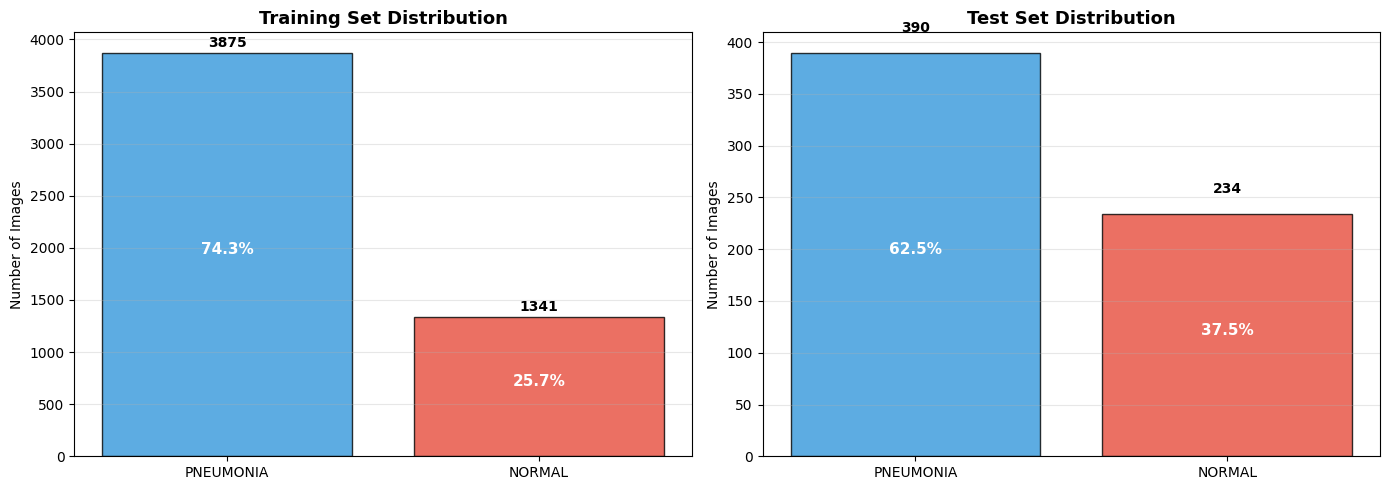


Class Imbalance Analysis:
Training set imbalance ratio: 2.89:1
Note: Dataset shows class imbalance. This may affect model performance.


In [28]:
# Create distribution visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
classes = list(train_stats.keys())
train_counts = list(train_stats.values())
colors = ['#3498db', '#e74c3c']

axes[0].bar(classes, train_counts, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_title('Training Set Distribution', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Images')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (c, count) in enumerate(zip(classes, train_counts)):
    axes[0].text(i, count + 50, str(count), ha='center', fontweight='bold')
    percentage = (count / sum(train_counts)) * 100
    axes[0].text(i, count/2, f'{percentage:.1f}%', ha='center',
                fontsize=11, fontweight='bold', color='white')

# Test set distribution
test_counts = list(test_stats.values())
axes[1].bar(classes, test_counts, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_title('Test Set Distribution', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Number of Images')
axes[1].grid(axis='y', alpha=0.3)

for i, (c, count) in enumerate(zip(classes, test_counts)):
    axes[1].text(i, count + 20, str(count), ha='center', fontweight='bold')
    percentage = (count / sum(test_counts)) * 100
    axes[1].text(i, count/2, f'{percentage:.1f}%', ha='center',
                fontsize=11, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Check for class imbalance
train_ratio = max(train_counts) / min(train_counts)
print(f"\nClass Imbalance Analysis:")
print(f"Training set imbalance ratio: {train_ratio:.2f}:1")
if train_ratio > 1.5:
    print("Note: Dataset shows class imbalance. This may affect model performance.")
else:
    print("Dataset is relatively balanced.")

## Section 7: Sample Image Visualization

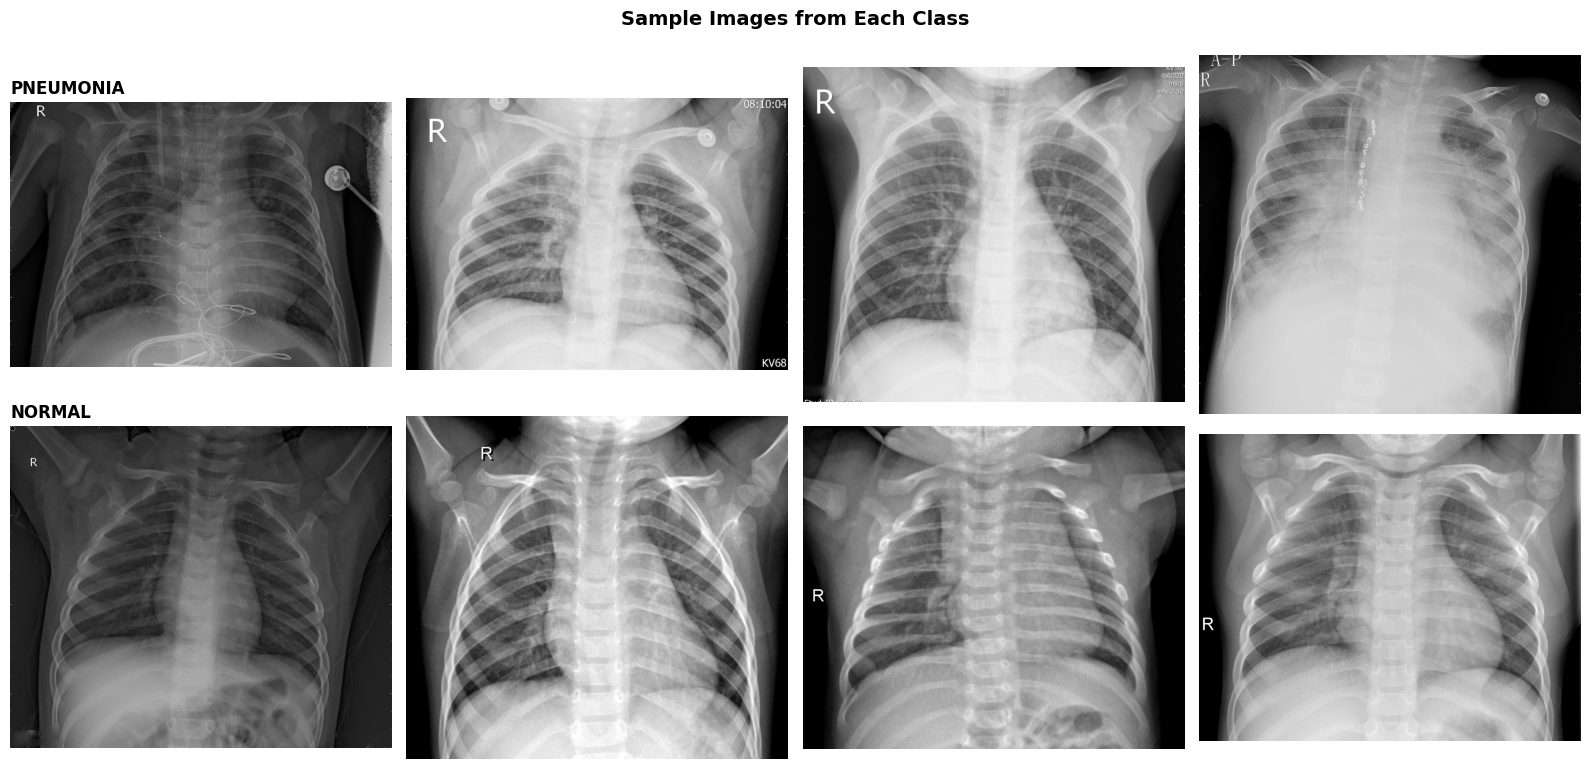

In [29]:
# Display sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for class_idx, class_name in enumerate(classes):
    class_path = train_dir / class_name
    image_files = (list(class_path.glob('*.jpeg')) +
                  list(class_path.glob('*.jpg')) +
                  list(class_path.glob('*.png')))

    # Display 4 samples per class
    for i in range(4):
        if i < len(image_files):
            img = cv2.imread(str(image_files[i]), cv2.IMREAD_GRAYSCALE)
            axes[class_idx, i].imshow(img, cmap='gray')
            axes[class_idx, i].axis('off')
            if i == 0:
                axes[class_idx, i].set_title(f'{class_name}',
                                            fontsize=12, fontweight='bold', loc='left')

plt.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Section 8: Image Dimension Analysis

Analyzing image dimensions (sampling 200 images)...

IMAGE DIMENSION STATISTICS
Height - Min: 191, Max: 2625, Mean: 1101
Width  - Min: 486, Max: 2694, Mean: 1416

Most common dimensions: [((776, 992), 2), ((584, 880), 2), ((744, 1072), 2)]


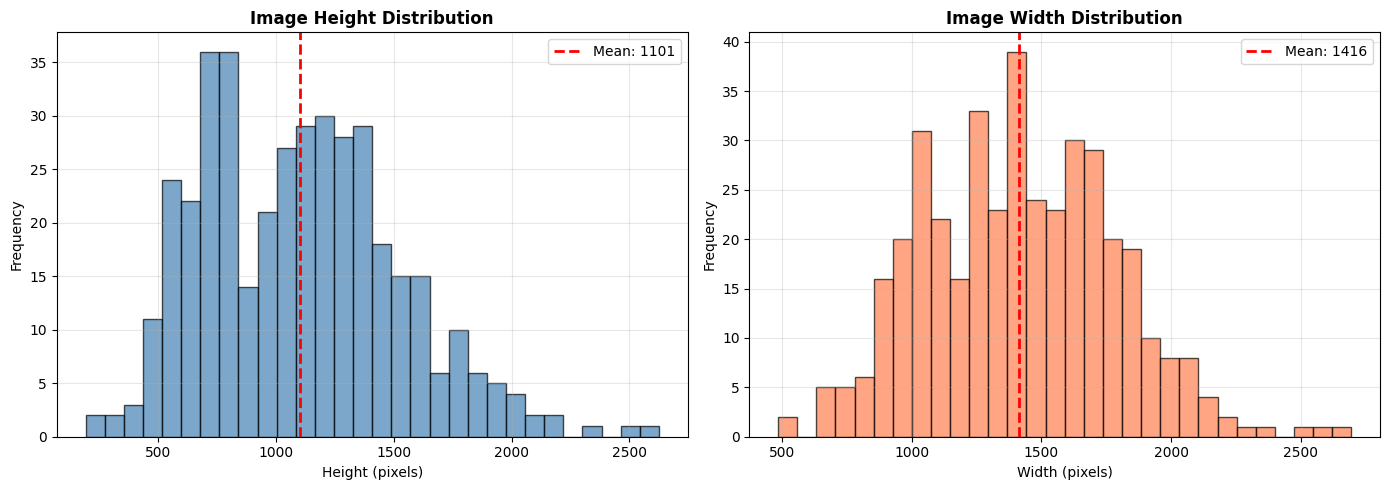

In [30]:
# Analyze image dimensions
print("Analyzing image dimensions (sampling 200 images)...\n")

dimensions = []
sample_size = 200

for class_name in classes:
    class_path = train_dir / class_name
    image_files = (list(class_path.glob('*.jpeg')) +
                  list(class_path.glob('*.jpg')) +
                  list(class_path.glob('*.png')))

    # Sample images
    sampled = random.sample(image_files, min(sample_size, len(image_files)))

    for img_path in sampled:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            dimensions.append(img.shape)

# Calculate statistics
heights = [d[0] for d in dimensions]
widths = [d[1] for d in dimensions]

print("IMAGE DIMENSION STATISTICS")
print("=" * 60)
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.0f}")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.0f}")
print(f"\nMost common dimensions: {Counter(dimensions).most_common(3)}")
print("=" * 60)

# Visualize dimension distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(heights, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(heights), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(heights):.0f}')
axes[0].set_title('Image Height Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Height (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(widths, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(widths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(widths):.0f}')
axes[1].set_title('Image Width Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Width (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Section 9: Pixel Intensity Analysis

Analyzing pixel intensity distributions...



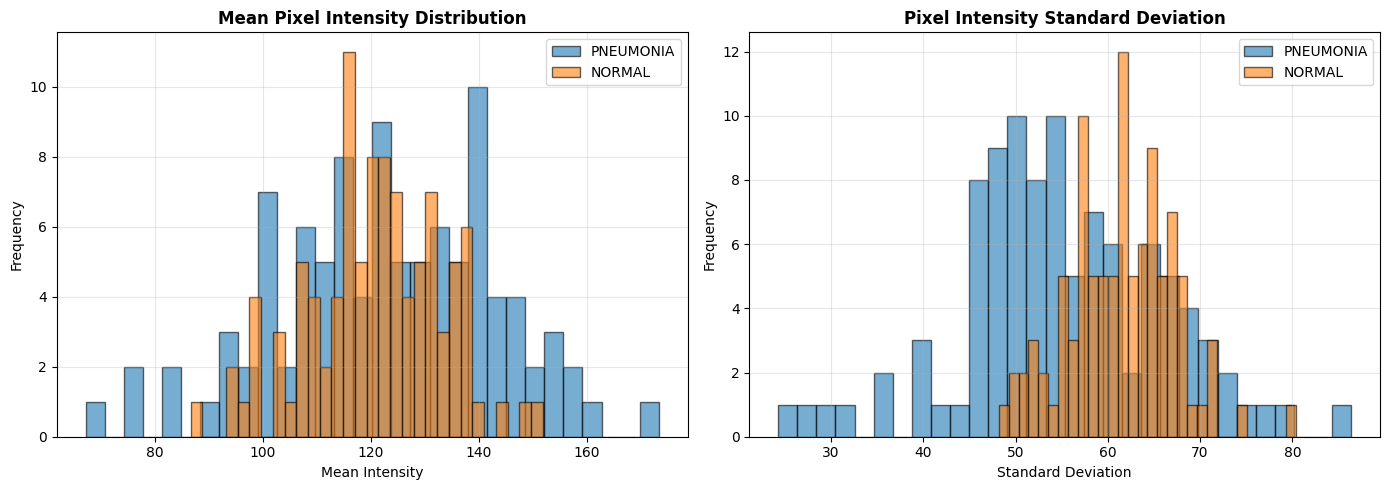


PIXEL INTENSITY STATISTICS BY CLASS
PNEUMONIA:
  Average mean intensity: 122.85
  Average std deviation: 55.08
NORMAL:
  Average mean intensity: 120.66
  Average std deviation: 61.40


In [31]:
# Analyze pixel intensity distributions by class
print("Analyzing pixel intensity distributions...\n")

intensity_stats = {}

for class_name in classes:
    class_path = train_dir / class_name
    image_files = (list(class_path.glob('*.jpeg')) +
                  list(class_path.glob('*.jpg')) +
                  list(class_path.glob('*.png')))

    sampled = random.sample(image_files, min(100, len(image_files)))

    mean_intensities = []
    std_intensities = []

    for img_path in sampled:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            mean_intensities.append(np.mean(img))
            std_intensities.append(np.std(img))

    intensity_stats[class_name] = {
        'mean': mean_intensities,
        'std': std_intensities
    }

# Visualize intensity distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, class_name in enumerate(classes):
    axes[0].hist(intensity_stats[class_name]['mean'], bins=30,
                alpha=0.6, label=class_name, edgecolor='black')
    axes[1].hist(intensity_stats[class_name]['std'], bins=30,
                alpha=0.6, label=class_name, edgecolor='black')

axes[0].set_title('Mean Pixel Intensity Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Mean Intensity')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].set_title('Pixel Intensity Standard Deviation', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Standard Deviation')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nPIXEL INTENSITY STATISTICS BY CLASS")
print("=" * 60)
for class_name in classes:
    mean_avg = np.mean(intensity_stats[class_name]['mean'])
    std_avg = np.mean(intensity_stats[class_name]['std'])
    print(f"{class_name}:")
    print(f"  Average mean intensity: {mean_avg:.2f}")
    print(f"  Average std deviation: {std_avg:.2f}")
print("=" * 60)

## Section 10: Data Preparation for Model Training

Based on our exploratory analysis, we now prepare the data for model training.

In [32]:
def load_image_paths_and_labels(directory):
    """
    Load all image paths and labels from directory structure
    """
    image_paths = []
    labels = []

    # Map class names to labels
    class_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}

    for class_name in class_mapping.keys():
        class_path = directory / class_name
        if class_path.exists():
            image_files = (list(class_path.glob('*.jpeg')) +
                          list(class_path.glob('*.jpg')) +
                          list(class_path.glob('*.png')))

            for img_path in image_files:
                image_paths.append(str(img_path))
                labels.append(class_mapping[class_name])

    return image_paths, labels

# Load training and test data
train_paths, train_labels = load_image_paths_and_labels(train_dir)
test_paths, test_labels = load_image_paths_and_labels(test_dir)

# Create validation split from training data
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=0.15,
    stratify=train_labels,
    random_state=SEED
)

print("DATA SPLIT SUMMARY")
print("=" * 60)
print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")
print(f"\nTraining - Normal: {train_labels.count(0)}, Pneumonia: {train_labels.count(1)}")
print(f"Validation - Normal: {val_labels.count(0)}, Pneumonia: {val_labels.count(1)}")
print(f"Test - Normal: {test_labels.count(0)}, Pneumonia: {test_labels.count(1)}")
print("=" * 60)

DATA SPLIT SUMMARY
Training samples: 4433
Validation samples: 783
Test samples: 624

Training - Normal: 1140, Pneumonia: 3293
Validation - Normal: 201, Pneumonia: 582
Test - Normal: 234, Pneumonia: 390


---
# PART 1: TRADITIONAL MACHINE LEARNING

We evaluate classical machine learning methods using handcrafted feature extraction.

---

## Section 11: Feature Extraction Functions

In [33]:
IMG_SIZE = (128, 128)

def extract_hog_features(image):
    features, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, channel_axis=None)
    return features

def extract_lbp_features(image, num_points=24, radius=3):
    lbp = local_binary_pattern(image, num_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3),
                          range=(0, num_points + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_glcm_features(image):
    image_normalized = ((image - image.min()) / (image.max() - image.min() + 1e-7) * 255).astype(np.uint8)
    glcm = graycomatrix(image_normalized, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast').ravel()
    dissimilarity = graycoprops(glcm, 'dissimilarity').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    correlation = graycoprops(glcm, 'correlation').ravel()

    return np.concatenate([contrast, dissimilarity, homogeneity, energy, correlation])

def extract_statistics(image):
    mean = np.mean(image)
    std = np.std(image)
    edges = sobel(image)
    edge_mean = np.mean(edges)
    return np.array([mean, std, edge_mean])

def extract_all_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, IMG_SIZE)
    img_normalized = img_resized / 255.0

    hog_feat = extract_hog_features(img_normalized)
    lbp_feat = extract_lbp_features(img_normalized)
    glcm_feat = extract_glcm_features(img_normalized)
    stat_feat = extract_statistics(img_normalized)

    return np.concatenate([hog_feat, lbp_feat, glcm_feat, stat_feat])

print("Feature extraction functions defined")
test_feat = extract_all_features(train_paths[0])
print(f"Feature vector length: {len(test_feat)}")

Feature extraction functions defined
Feature vector length: 8149


## Section 12: Extract Features from Dataset

In [34]:
print("Extracting features from training set...\n")

X_train_features = []
for img_path in tqdm(train_paths, desc="Training"):
    X_train_features.append(extract_all_features(img_path))

X_train_features = np.array(X_train_features)
y_train = np.array(train_labels)

print(f"\nExtracting features from validation set...\n")

X_val_features = []
for img_path in tqdm(val_paths, desc="Validation"):
    X_val_features.append(extract_all_features(img_path))

X_val_features = np.array(X_val_features)
y_val = np.array(val_labels)

print(f"\nFeature extraction completed")
print(f"Training features: {X_train_features.shape}")
print(f"Validation features: {X_val_features.shape}")

Extracting features from training set...



Training: 100%|██████████| 4433/4433 [07:42<00:00,  9.58it/s]



Extracting features from validation set...



Validation: 100%|██████████| 783/783 [01:15<00:00, 10.38it/s]


Feature extraction completed
Training features: (4433, 8149)
Validation features: (783, 8149)


## Section 13: Feature Preprocessing

In [35]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)

# PCA
pca = PCA(n_components=0.95, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA features: {X_train_pca.shape[1]}")
print(f"Variance retained: {pca.explained_variance_ratio_.sum():.2%}")

Original features: 8149
PCA features: 1574
Variance retained: 95.00%


## Section 14: Traditional ML Training Function

In [36]:
def train_evaluate_ml(model, X_train, X_val, y_train, y_val, name):
    print(f"\nTraining {name}...")
    start = time.time()

    model.fit(X_train, y_train)
    training_time = time.time() - start

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    try:
        auc = roc_auc_score(y_val, y_proba)
    except:
        auc = 0.0

    print(f"Completed in {training_time:.2f}s - Accuracy: {acc:.4f}")

    return {
        'model_name': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': auc,
        'training_time': training_time,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

## Section 15: Train All Traditional ML Models

In [37]:
# Train all models
ml_results = []

models = [
    (LogisticRegression(max_iter=1000, random_state=SEED), "Logistic Regression"),
    (SVC(kernel='linear', probability=True, random_state=SEED), "SVM (Linear)"),
    (SVC(kernel='rbf', probability=True, random_state=SEED), "SVM (RBF)"),
    (RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1), "Random Forest"),
    (KNeighborsClassifier(n_neighbors=5), "K-Nearest Neighbors"),
    (GradientBoostingClassifier(n_estimators=100, random_state=SEED), "Gradient Boosting"),
    (GaussianNB(), "Naive Bayes")
]

for model, name in models:
    result = train_evaluate_ml(model, X_train_pca, X_val_pca, y_train, y_val, name)
    ml_results.append(result)

print("\nAll traditional ML models trained")


Training Logistic Regression...
Completed in 1.72s - Accuracy: 0.9732

Training SVM (Linear)...
Completed in 13.72s - Accuracy: 0.9757

Training SVM (RBF)...
Completed in 31.57s - Accuracy: 0.9834

Training Random Forest...
Completed in 22.58s - Accuracy: 0.7867

Training K-Nearest Neighbors...
Completed in 0.03s - Accuracy: 0.9553

Training Gradient Boosting...
Completed in 358.01s - Accuracy: 0.9591

Training Naive Bayes...
Completed in 0.12s - Accuracy: 0.5632

All traditional ML models trained


## Section 16: Traditional ML Results Summary

In [38]:
ml_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Accuracy': r['accuracy'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'F1-Score': r['f1_score'],
    'ROC-AUC': r['roc_auc'],
    'Time (s)': r['training_time']
} for r in ml_results])

print("\n" + "="*90)
print("TRADITIONAL MACHINE LEARNING - PERFORMANCE SUMMARY")
print("="*90)
print(ml_df.to_string(index=False))
print("="*90)


TRADITIONAL MACHINE LEARNING - PERFORMANCE SUMMARY
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   Time (s)
Logistic Regression  0.973180   0.991243 0.972509  0.981787 0.997367   1.719663
       SVM (Linear)  0.975734   0.987868 0.979381  0.983607 0.997397  13.717899
          SVM (RBF)  0.983397   0.994783 0.982818  0.988764 0.998000  31.570754
      Random Forest  0.786718   0.777036 1.000000  0.874530 0.944073  22.578506
K-Nearest Neighbors  0.955300   0.994575 0.945017  0.969163 0.990003   0.030132
  Gradient Boosting  0.959132   0.967687 0.977663  0.972650 0.993110 358.009104
        Naive Bayes  0.563218   0.976190 0.422680  0.589928 0.880623   0.120424


## Section 17: Best Traditional ML Model Visualization

Best Model: SVM (RBF)
Accuracy: 0.9834



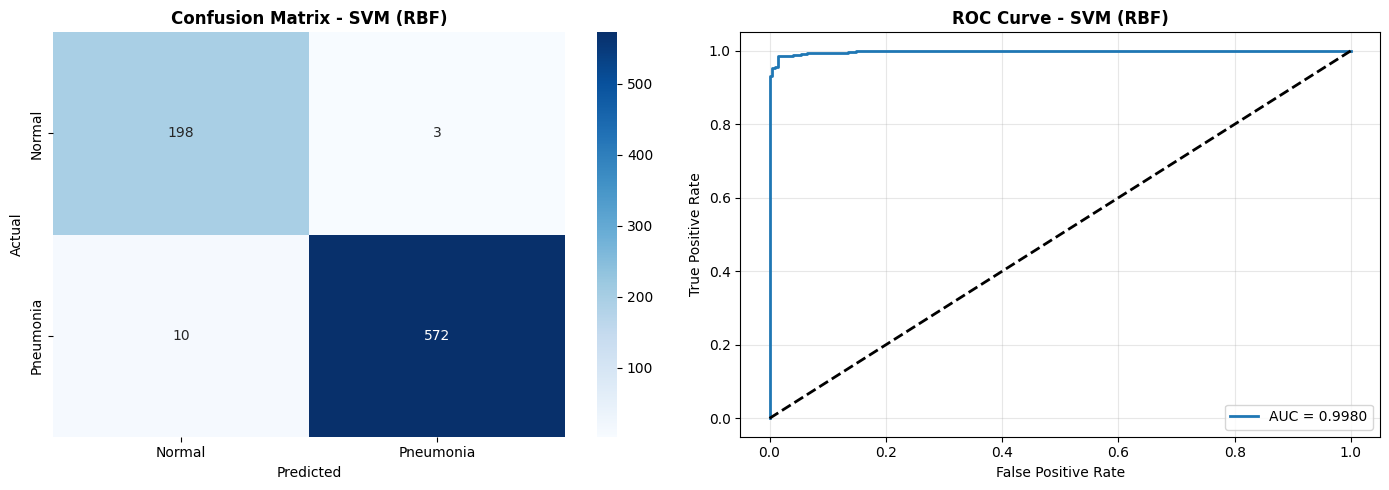

In [39]:
best_ml_idx = ml_df['Accuracy'].idxmax()
best_ml = ml_results[best_ml_idx]

print(f"Best Model: {best_ml['model_name']}")
print(f"Accuracy: {best_ml['accuracy']:.4f}\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_val, best_ml['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
axes[0].set_title(f'Confusion Matrix - {best_ml["model_name"]}', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

fpr, tpr, _ = roc_curve(y_val, best_ml['y_proba'])
axes[1].plot(fpr, tpr, label=f"AUC = {best_ml['roc_auc']:.4f}", lw=2)
axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_title(f'ROC Curve - {best_ml["model_name"]}', fontweight='bold')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
# PART 2: DEEP LEARNING

We evaluate modern deep learning architectures with automatic feature learning.

---

## Section 18: TensorFlow Dataset Creation

In [40]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

def create_tf_dataset(paths, labels, batch_size, shuffle=True):
    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        return img, label

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_tf_dataset(train_paths, train_labels, BATCH_SIZE, True)
val_ds = create_tf_dataset(val_paths, val_labels, BATCH_SIZE, False)

print("TensorFlow datasets created")

TensorFlow datasets created


## Section 19: Deep Learning Helper Functions

In [41]:
def plot_history(history, name):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(history.history['loss'], lw=2, color='red')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].grid(alpha=0.3)

    axes[0, 1].plot(history.history['accuracy'], lw=2, color='green')
    axes[0, 1].set_title('Training Accuracy')
    axes[0, 1].grid(alpha=0.3)

    axes[1, 0].plot(history.history['accuracy'], label='Train', lw=2)
    axes[1, 0].plot(history.history['val_accuracy'], label='Val', lw=2)
    axes[1, 0].set_title('Accuracy Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    axes[1, 1].plot(history.history['loss'], label='Train', lw=2)
    axes[1, 1].plot(history.history['val_loss'], label='Val', lw=2)
    axes[1, 1].set_title('Loss Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.suptitle(f'{name} - Training History', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def evaluate_dl(model, dataset, name):
    print(f"\nEvaluating {name}...")

    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_proba = model.predict(dataset, verbose=0)
    y_pred = (y_proba > 0.5).astype(int).flatten()

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}, ROC-AUC: {auc:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    axes[0].set_title(f'Confusion Matrix - {name}', fontweight='bold')

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    axes[1].plot(fpr, tpr, label=f"AUC = {auc:.4f}", lw=2)
    axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[1].set_title(f'ROC Curve - {name}', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1, 'roc_auc': auc}

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                           restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                              patience=3, min_lr=1e-7, verbose=1)

print("Helper functions configured")

Helper functions configured


## Section 20: Baseline CNN

Training Baseline CNN...

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 54s 350ms/step - accuracy: 0.8296 - loss: 0.3704 - val_accuracy: 0.9604 - val_loss: 0.1063
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - accuracy: 0.9580 - loss: 0.1083 - val_accuracy: 0.9553 - val_loss: 0.1123
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - accuracy: 0.9697 - loss: 0.0768 - val_accuracy: 0.9796 - val_loss: 0.0717
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.9752 - loss: 0.0646 - val_accuracy: 0.9668 - val_loss: 0.0931
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.9804 - loss: 0.0569 - val_accuracy: 0.9783 - val_loss: 0.0718
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - accuracy: 0.9825 - loss: 0.0455 - val_accuracy: 0.9796 - val_loss: 0.0816
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - accuracy: 0.9907 - loss: 0.0305 - val_accuracy: 0.9757 - val_loss: 0.1022
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - 

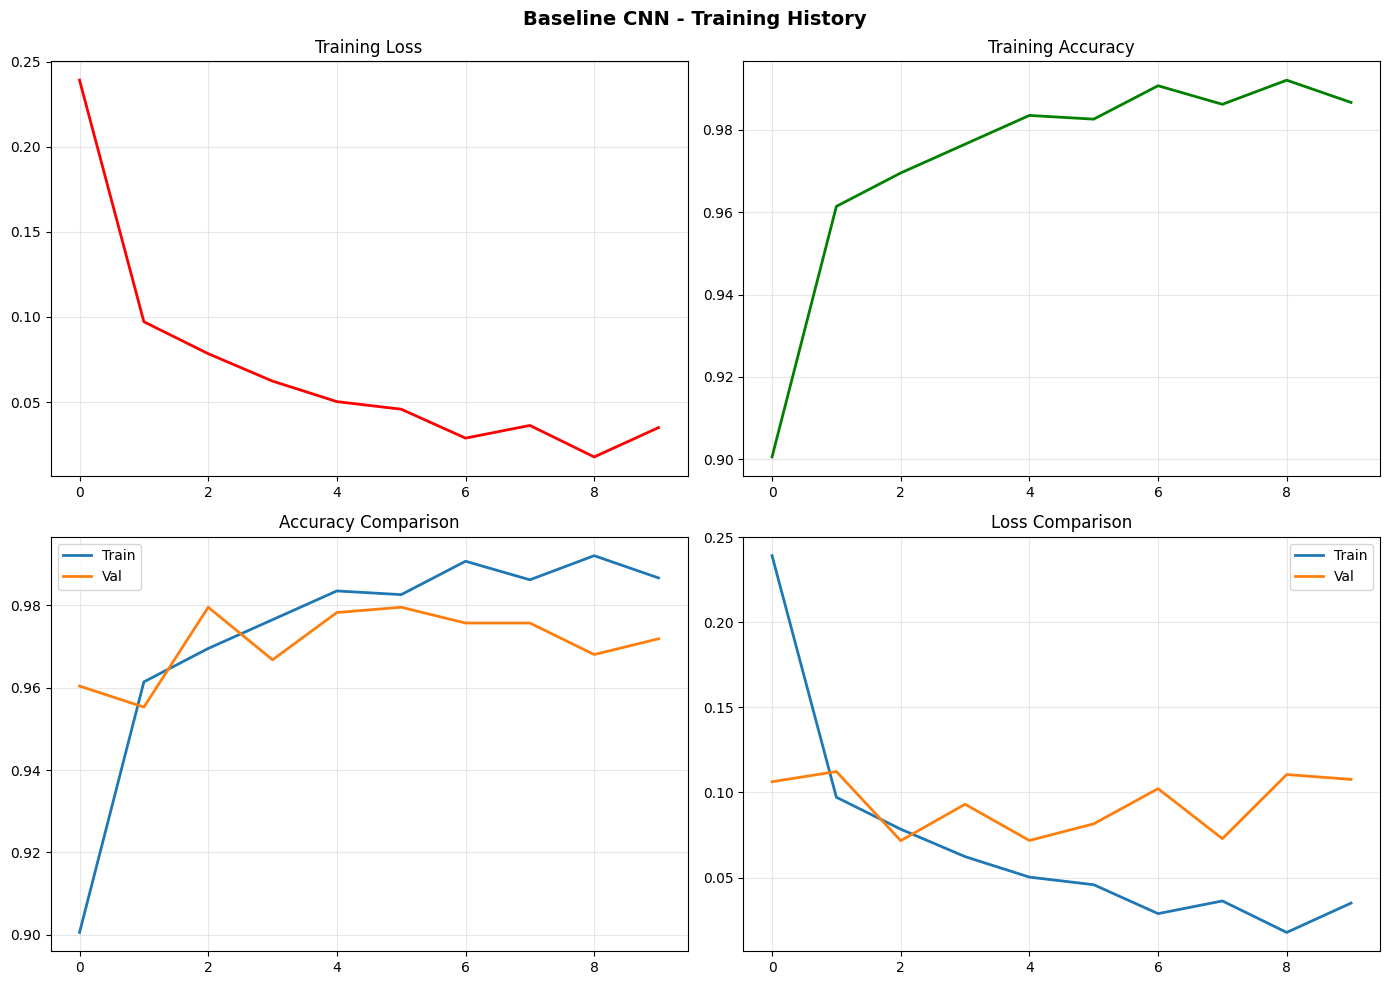


Evaluating Baseline CNN...
Accuracy: 0.9719, Precision: 0.9746, Recall: 0.9880
F1-Score: 0.9812, ROC-AUC: 0.9944


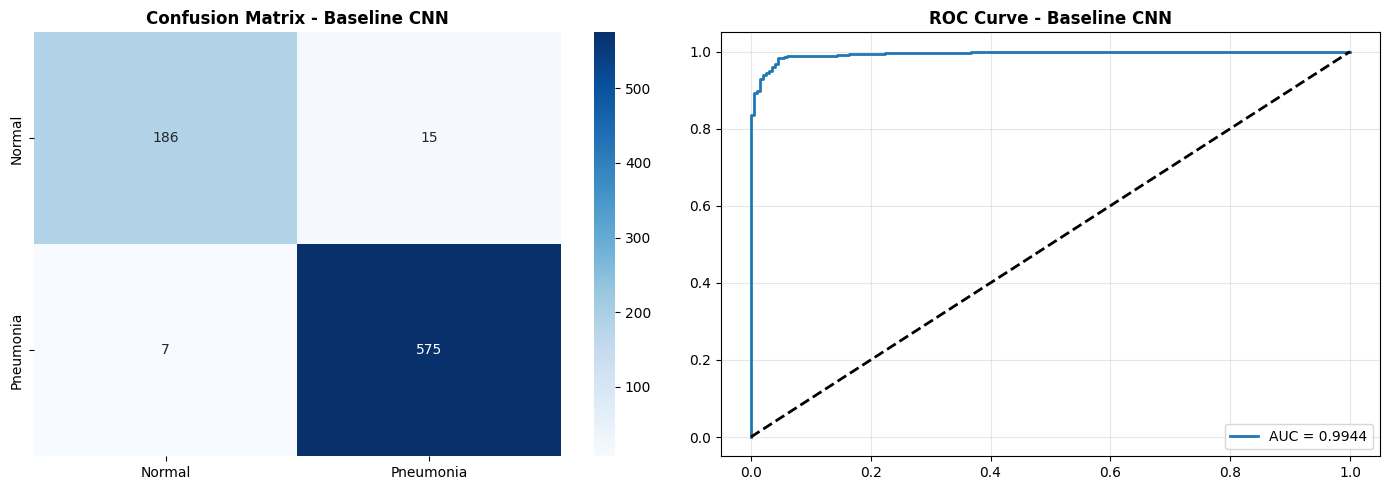

In [42]:
print("Training Baseline CNN...\n")

dl1 = Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

dl1.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss='binary_crossentropy', metrics=['accuracy'])

h1 = dl1.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

plot_history(h1, "Baseline CNN")
dl1_metrics = evaluate_dl(dl1, val_ds, "Baseline CNN")

## Section 21: CNN with Dropout

Training CNN with Dropout...

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 37s 239ms/step - accuracy: 0.8235 - loss: 0.4132 - val_accuracy: 0.9553 - val_loss: 0.1218
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - accuracy: 0.9462 - loss: 0.1509 - val_accuracy: 0.9655 - val_loss: 0.0859
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9475 - loss: 0.1305 - val_accuracy: 0.9374 - val_loss: 0.1513
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.9519 - loss: 0.1263 - val_accuracy: 0.9706 - val_loss: 0.0671
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.9647 - loss: 0.0996 - val_accuracy: 0.9808 - val_loss: 0.0561
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.9699 - loss: 0.0795 - val_accuracy: 0.9770 - val_loss: 0.0647
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - accuracy: 0.9773 - loss: 0.0621 - val_accuracy: 0.9693 - val_loss: 0.0720
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/ste

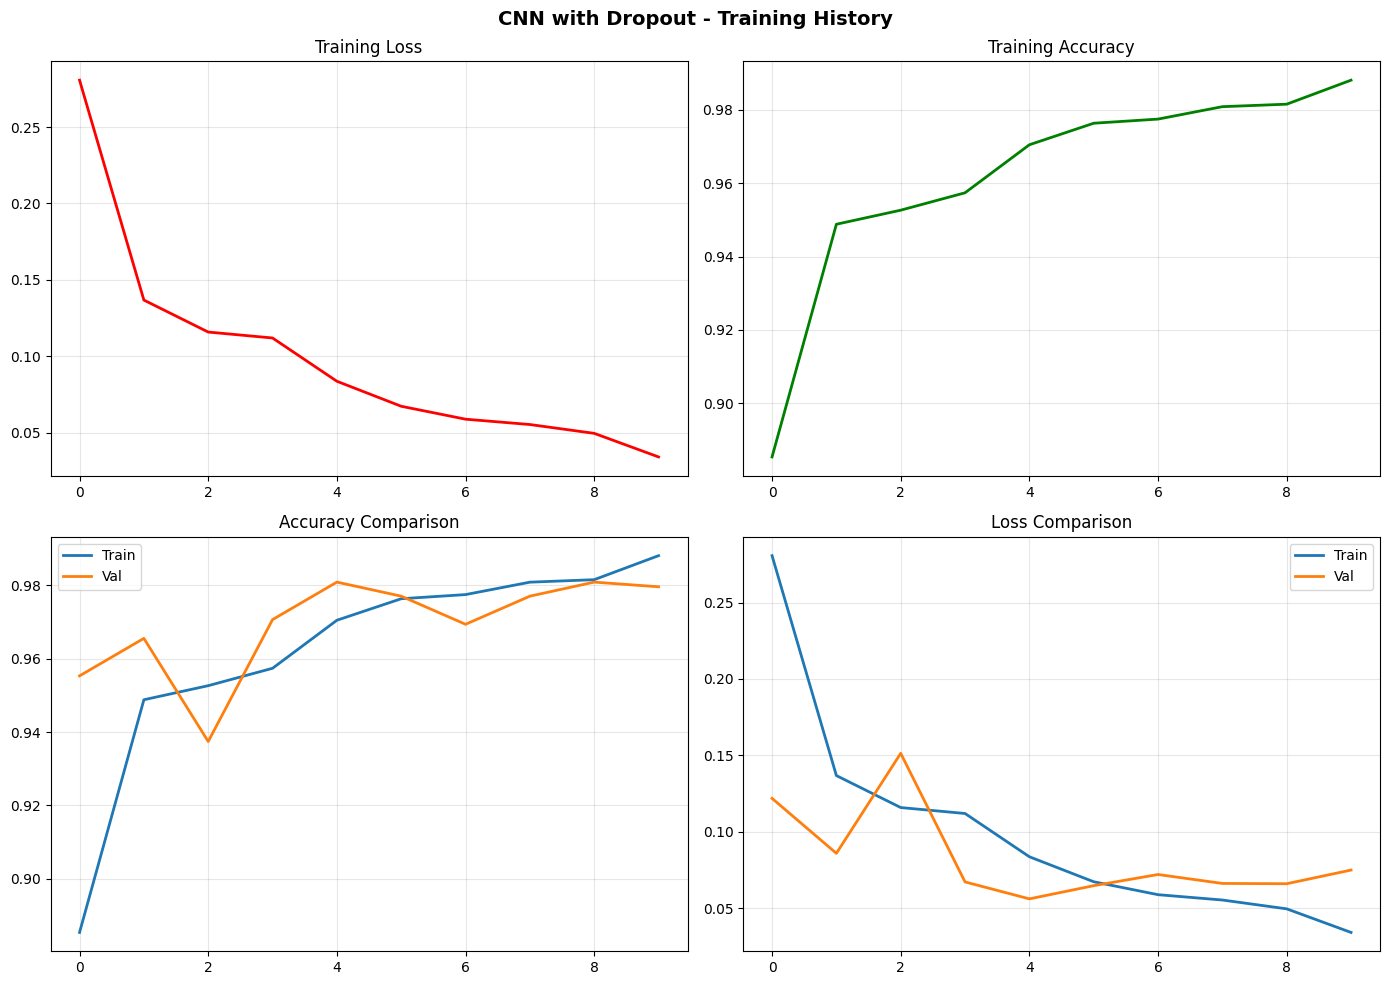


Evaluating CNN with Dropout...
Accuracy: 0.9796, Precision: 0.9863, Recall: 0.9863
F1-Score: 0.9863, ROC-AUC: 0.9968


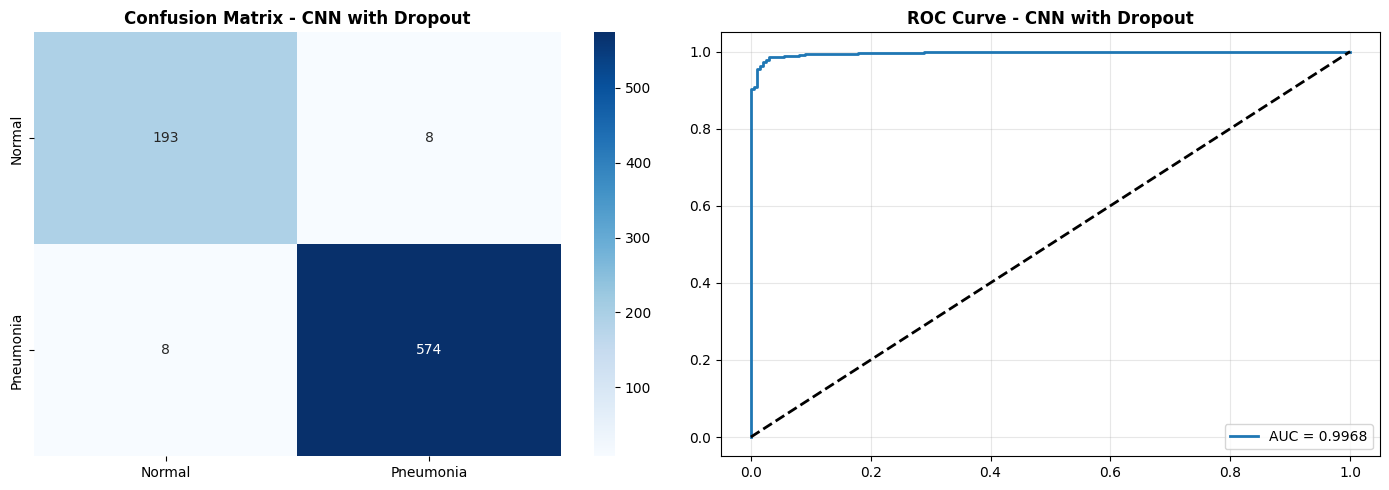

In [43]:
print("Training CNN with Dropout...\n")

dl2 = Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

dl2.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss='binary_crossentropy', metrics=['accuracy'])

h2 = dl2.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

plot_history(h2, "CNN with Dropout")
dl2_metrics = evaluate_dl(dl2, val_ds, "CNN with Dropout")

## Section 22: MobileNetV2 Transfer Learning

In [44]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False,
                             input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
mobilenet_base.trainable = False

print(f"MobileNetV2 loaded: {mobilenet_base.count_params():,} parameters")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
MobileNetV2 loaded: 2,257,984 parameters


Training MobileNetV2...

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 74s 405ms/step - accuracy: 0.8241 - loss: 0.3658 - val_accuracy: 0.9527 - val_loss: 0.1491
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - accuracy: 0.9485 - loss: 0.1358 - val_accuracy: 0.9604 - val_loss: 0.1199
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.9658 - loss: 0.0994 - val_accuracy: 0.9566 - val_loss: 0.1109
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - accuracy: 0.9667 - loss: 0.0920 - val_accuracy: 0.9591 - val_loss: 0.1080
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step - accuracy: 0.9711 - loss: 0.0774 - val_accuracy: 0.9655 - val_loss: 0.1035
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.9760 - loss: 0.0711 - val_accuracy: 0.9655 - val_loss: 0.1006
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - accuracy: 0.9791 - loss: 0.0656 - val_accuracy: 0.9668 - val_loss: 0.1051
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - a

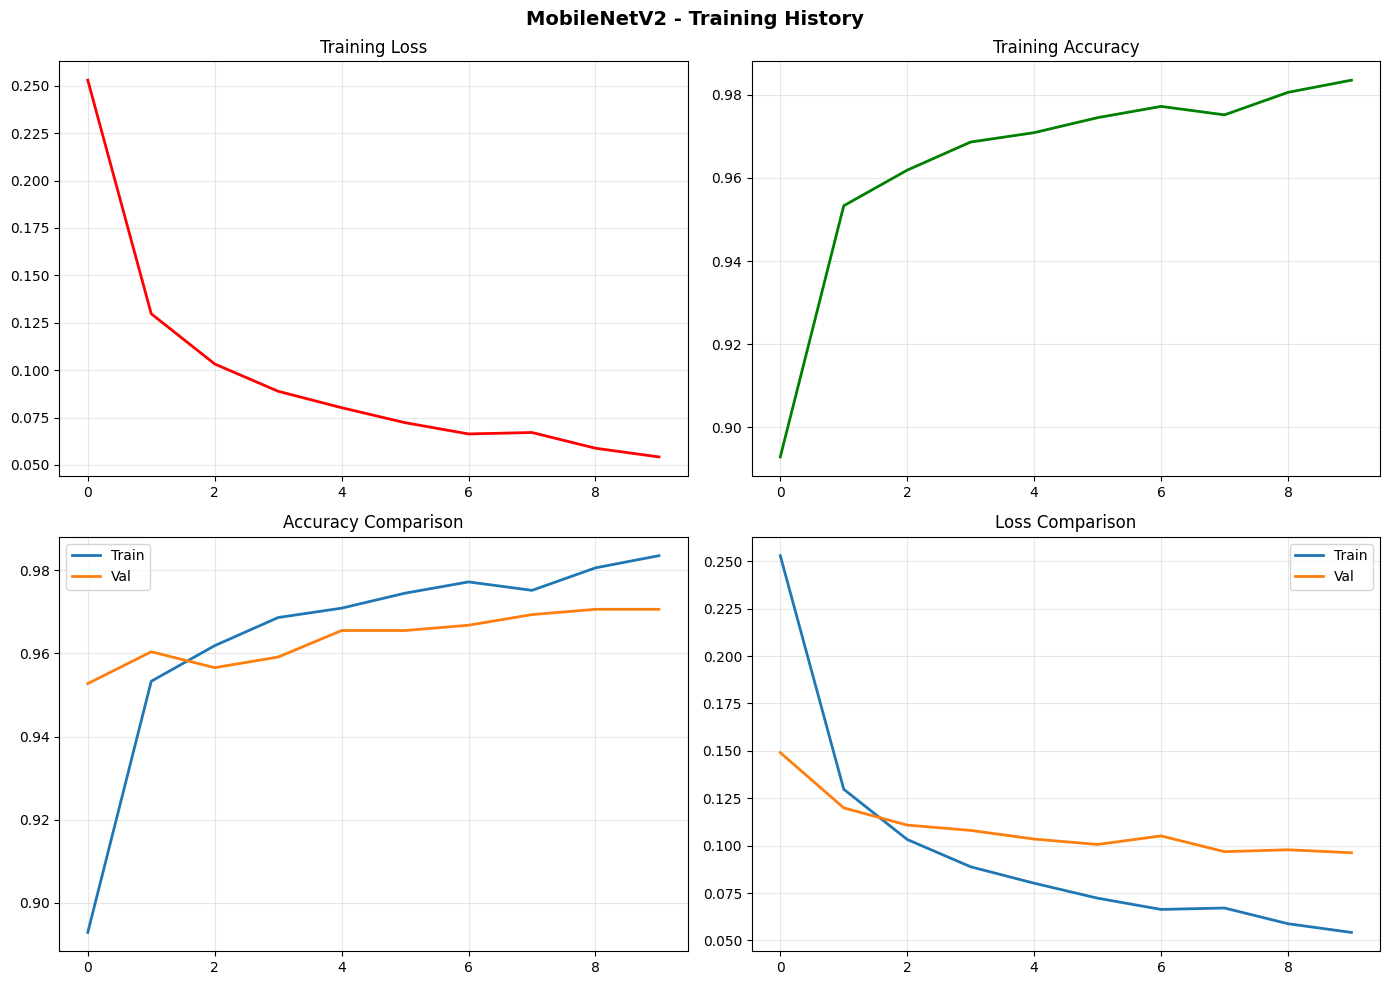


Evaluating MobileNetV2...
Accuracy: 0.9706, Precision: 0.9794, Recall: 0.9811
F1-Score: 0.9803, ROC-AUC: 0.9910


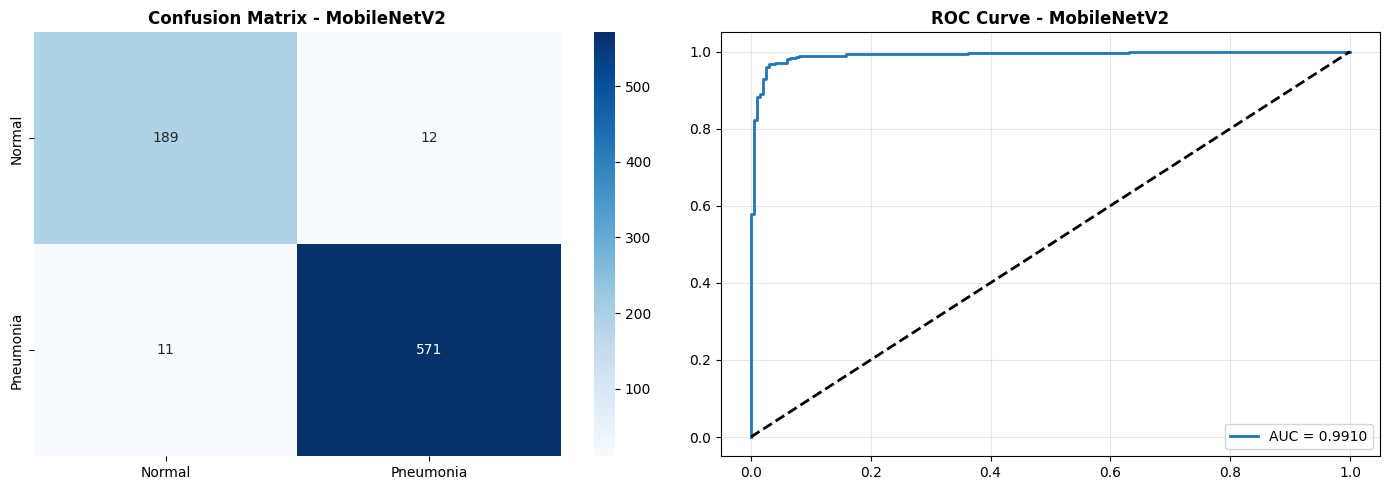

In [45]:
print("Training MobileNetV2...\n")

dl3 = Sequential([
    layers.Lambda(lambda x: keras.applications.mobilenet_v2.preprocess_input(x)),
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

dl3.compile(optimizer=keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy', metrics=['accuracy'])

h3 = dl3.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

plot_history(h3, "MobileNetV2")
dl3_metrics = evaluate_dl(dl3, val_ds, "MobileNetV2")

## Section 23: MobileNetV2 with Regularization

Training MobileNetV2 with Regularization...

Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 52s 304ms/step - accuracy: 0.7274 - loss: 2.7257 - val_accuracy: 0.9438 - val_loss: 1.9087 - learning_rate: 1.0000e-04
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - accuracy: 0.9187 - loss: 1.8302 - val_accuracy: 0.9566 - val_loss: 1.4629 - learning_rate: 1.0000e-04
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.9357 - loss: 1.4081 - val_accuracy: 0.9604 - val_loss: 1.1647 - learning_rate: 1.0000e-04
Epoch 4/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.9459 - loss: 1.1202 - val_accuracy: 0.9630 - val_loss: 0.9541 - learning_rate: 1.0000e-04
Epoch 5/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - accuracy: 0.9523 - loss: 0.9194 - val_accuracy: 0.9617 - val_loss: 0.8101 - learning_rate: 1.0000e-04
Epoch 6/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 217ms/step - accuracy: 0.9563 - loss: 0.7826 - val_accuracy: 0.9591 - val_loss: 0.7069 - learning_rate: 1.0000e-04
E

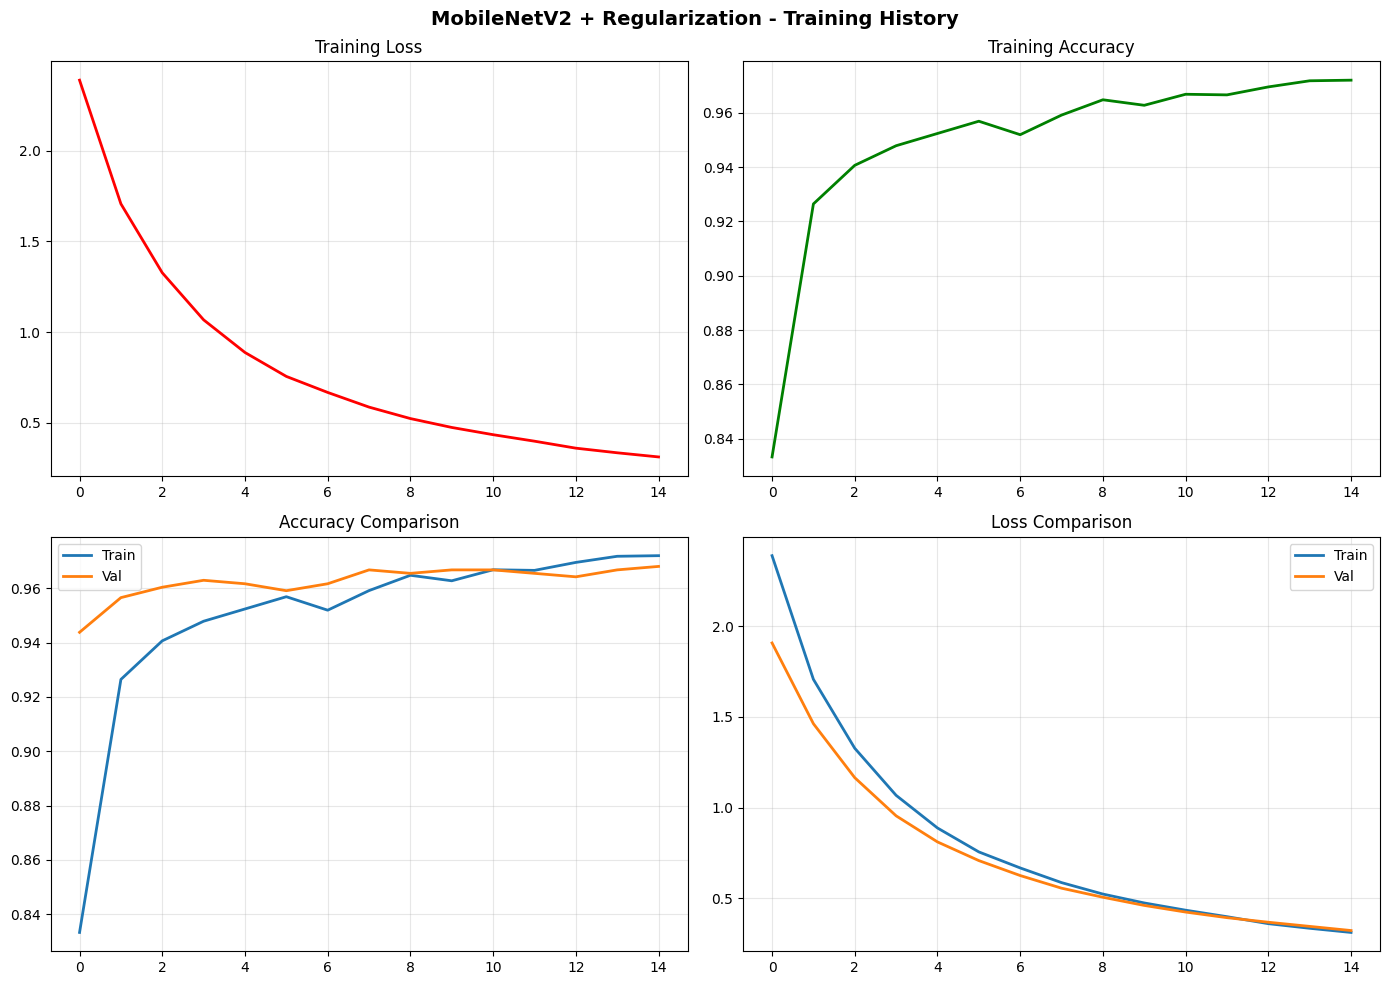


Evaluating MobileNetV2 + Regularization...
Accuracy: 0.9681, Precision: 0.9744, Recall: 0.9828
F1-Score: 0.9786, ROC-AUC: 0.9898


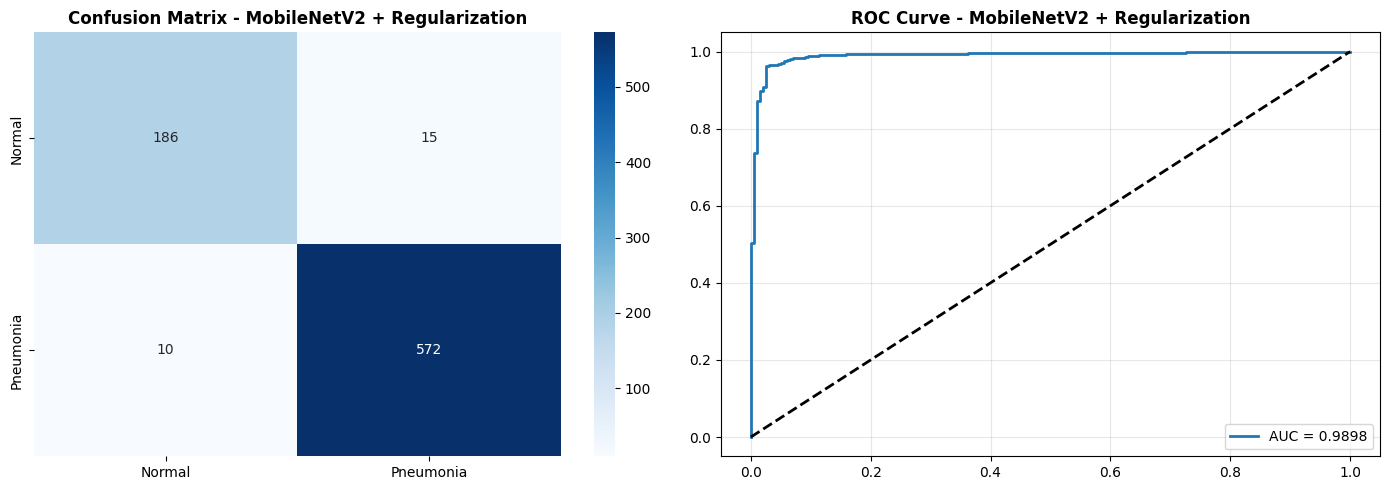

In [46]:
print("Training MobileNetV2 with Regularization...\n")

dl4 = Sequential([
    layers.Lambda(lambda x: keras.applications.mobilenet_v2.preprocess_input(x)),
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

dl4.compile(optimizer=keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy', metrics=['accuracy'])

h4 = dl4.fit(train_ds, validation_data=val_ds, epochs=15,
             callbacks=[early_stop, reduce_lr], verbose=1)

plot_history(h4, "MobileNetV2 + Regularization")
dl4_metrics = evaluate_dl(dl4, val_ds, "MobileNetV2 + Regularization")

## Section 24: ResNet50 Transfer Learning

In [47]:
resnet_base = ResNet50(weights='imagenet', include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
resnet_base.trainable = False

print(f"ResNet50 loaded: {resnet_base.count_params():,} parameters")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
ResNet50 loaded: 23,587,712 parameters


Training ResNet50...

Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 55s 308ms/step - accuracy: 0.7291 - loss: 3.1598 - val_accuracy: 0.9464 - val_loss: 2.0537 - learning_rate: 1.0000e-04
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 65s 225ms/step - accuracy: 0.9189 - loss: 2.0147 - val_accuracy: 0.9604 - val_loss: 1.6439 - learning_rate: 1.0000e-04
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 231ms/step - accuracy: 0.9449 - loss: 1.5984 - val_accuracy: 0.9502 - val_loss: 1.3733 - learning_rate: 1.0000e-04
Epoch 4/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.9521 - loss: 1.3311 - val_accuracy: 0.9604 - val_loss: 1.1449 - learning_rate: 1.0000e-04
Epoch 5/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.9539 - loss: 1.1323 - val_accuracy: 0.9604 - val_loss: 0.9894 - learning_rate: 1.0000e-04
Epoch 6/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 226ms/step - accuracy: 0.9647 - loss: 0.9641 - val_accuracy: 0.9604 - val_loss: 0.8620 - learning_rate: 1.0000e-04
Epoch 7/15
139/139 ━━━━━

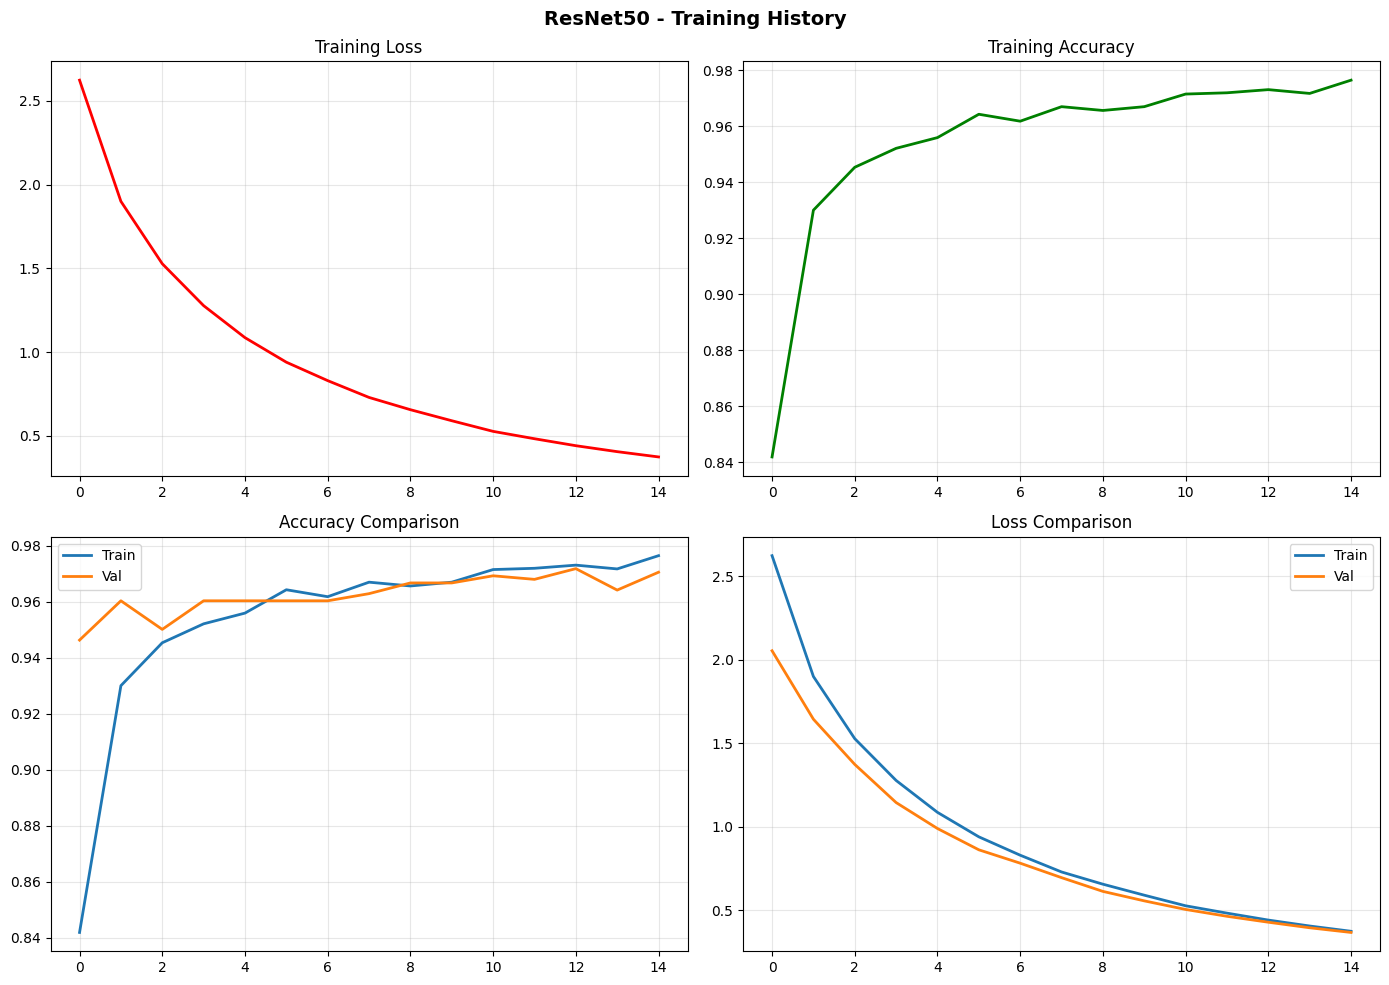


Evaluating ResNet50...
Accuracy: 0.9706, Precision: 0.9827, Recall: 0.9777
F1-Score: 0.9802, ROC-AUC: 0.9954


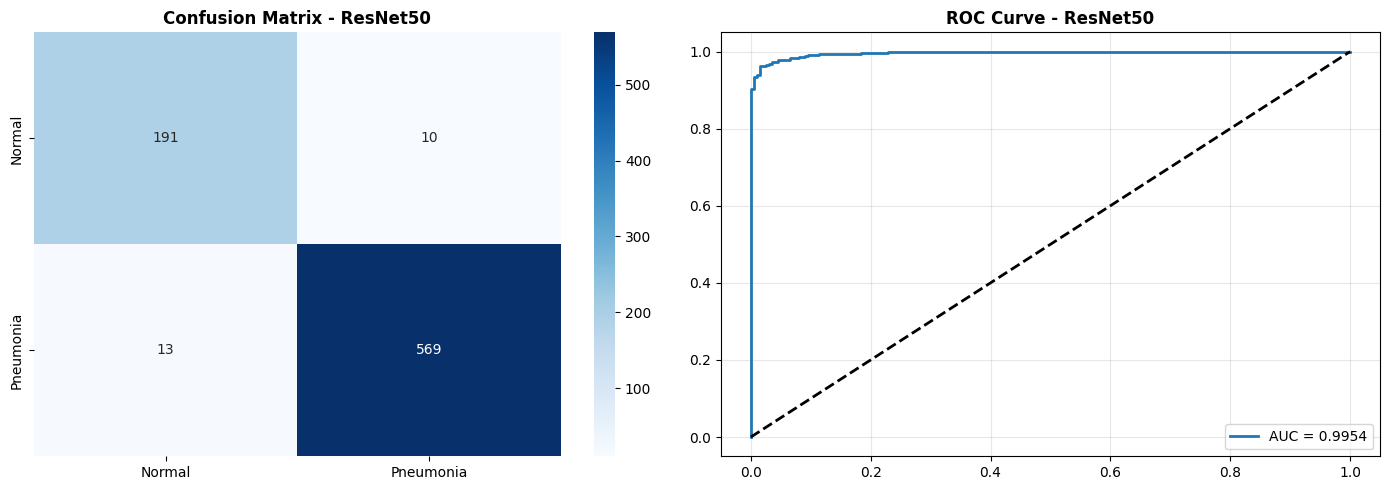

In [48]:
print("Training ResNet50...\n")

dl5 = Sequential([
    layers.Lambda(lambda x: keras.applications.resnet50.preprocess_input(x)),
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

dl5.compile(optimizer=keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy', metrics=['accuracy'])

h5 = dl5.fit(train_ds, validation_data=val_ds, epochs=15,
             callbacks=[early_stop, reduce_lr], verbose=1)

plot_history(h5, "ResNet50")
dl5_metrics = evaluate_dl(dl5, val_ds, "ResNet50")

## Section 25: Deep Learning Results Summary

In [49]:
dl_df = pd.DataFrame([
    {'Model': 'Baseline CNN', **dl1_metrics},
    {'Model': 'CNN + Dropout', **dl2_metrics},
    {'Model': 'MobileNetV2', **dl3_metrics},
    {'Model': 'MobileNetV2 + Reg', **dl4_metrics},
    {'Model': 'ResNet50', **dl5_metrics}
])

print("\n" + "="*90)
print("DEEP LEARNING - PERFORMANCE SUMMARY")
print("="*90)
print(dl_df.to_string(index=False))
print("="*90)


DEEP LEARNING - PERFORMANCE SUMMARY
            Model  accuracy  precision   recall  f1_score  roc_auc
     Baseline CNN  0.971903   0.974576 0.987973  0.981229 0.994384
    CNN + Dropout  0.979566   0.986254 0.986254  0.986254 0.996786
      MobileNetV2  0.970626   0.979417 0.981100  0.980258 0.991050
MobileNetV2 + Reg  0.968072   0.974446 0.982818  0.978614 0.989845
         ResNet50  0.970626   0.982729 0.977663  0.980189 0.995367


---
# COMPREHENSIVE COMPARISON
---

## Section 26: Combined Results

In [50]:
ml_df['Approach'] = 'Traditional ML'
dl_df['Approach'] = 'Deep Learning'

all_results = pd.concat([
    ml_df[['Approach', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']],
    dl_df[['Approach', 'Model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].rename(columns={
        'accuracy': 'Accuracy', 'precision': 'Precision', 'recall': 'Recall',
        'f1_score': 'F1-Score', 'roc_auc': 'ROC-AUC'
    })
], ignore_index=True)

all_sorted = all_results.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("COMPLETE COMPARISON: TRADITIONAL ML vs DEEP LEARNING")
print("="*100)
print(all_sorted.to_string(index=False))
print("="*100)


COMPLETE COMPARISON: TRADITIONAL ML vs DEEP LEARNING
      Approach               Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Traditional ML           SVM (RBF)  0.983397   0.994783 0.982818  0.988764 0.998000
 Deep Learning       CNN + Dropout  0.979566   0.986254 0.986254  0.986254 0.996786
Traditional ML        SVM (Linear)  0.975734   0.987868 0.979381  0.983607 0.997397
Traditional ML Logistic Regression  0.973180   0.991243 0.972509  0.981787 0.997367
 Deep Learning        Baseline CNN  0.971903   0.974576 0.987973  0.981229 0.994384
 Deep Learning         MobileNetV2  0.970626   0.979417 0.981100  0.980258 0.991050
 Deep Learning            ResNet50  0.970626   0.982729 0.977663  0.980189 0.995367
 Deep Learning   MobileNetV2 + Reg  0.968072   0.974446 0.982818  0.978614 0.989845
Traditional ML   Gradient Boosting  0.959132   0.967687 0.977663  0.972650 0.993110
Traditional ML K-Nearest Neighbors  0.955300   0.994575 0.945017  0.969163 0.990003
Traditional ML       R

## Section 27: Visual Comparison

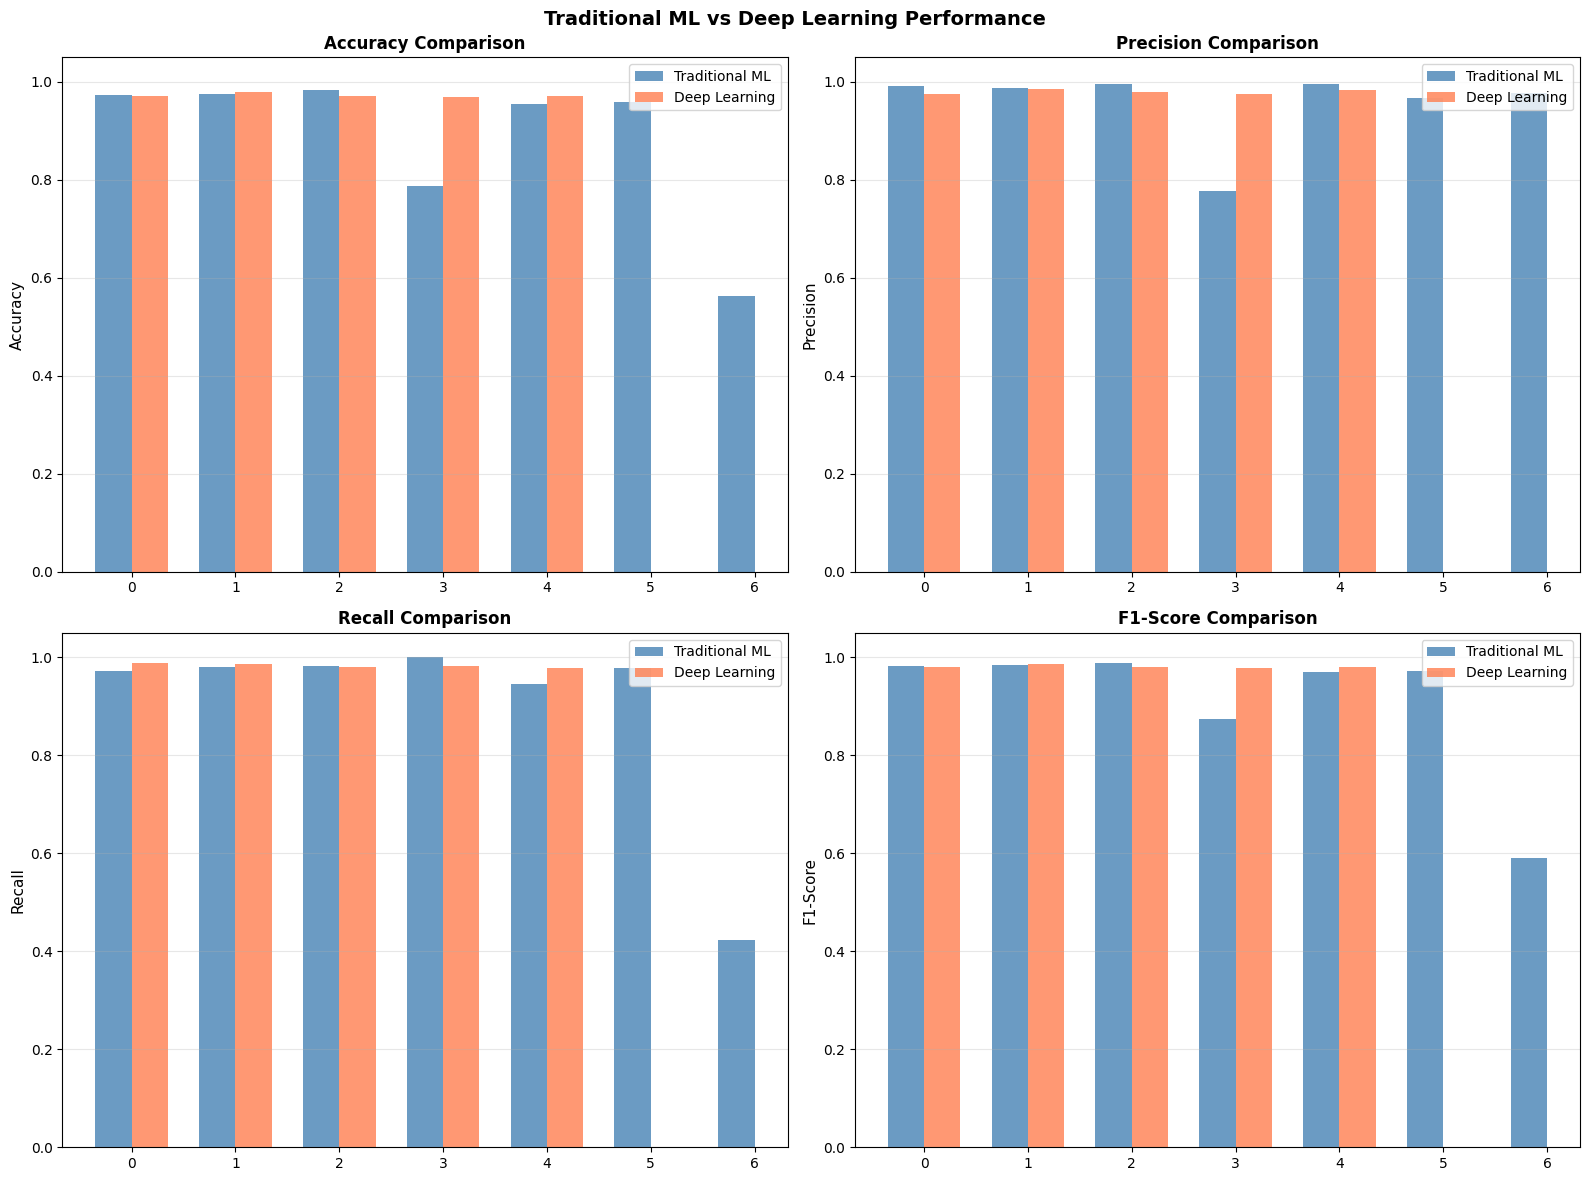

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
ml_data = all_results[all_results['Approach'] == 'Traditional ML']
dl_data = all_results[all_results['Approach'] == 'Deep Learning']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    x = np.arange(max(len(ml_data), len(dl_data)))
    width = 0.35

    ax.bar(x[:len(ml_data)] - width/2, ml_data[metric], width,
           label='Traditional ML', color='steelblue', alpha=0.8)
    ax.bar(x[:len(dl_data)] + width/2, dl_data[metric], width,
           label='Deep Learning', color='coral', alpha=0.8)

    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.05])

plt.suptitle('Traditional ML vs Deep Learning Performance',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Section 28: Summary Statistics

In [52]:
summary = all_results.groupby('Approach')[['Accuracy', 'Precision', 'Recall',
                                            'F1-Score', 'ROC-AUC']].agg(['mean', 'std', 'max'])

print("\n" + "="*100)
print("SUMMARY STATISTICS BY APPROACH")
print("="*100)
print(summary.round(4))
print("="*100)


SUMMARY STATISTICS BY APPROACH
               Accuracy                 Precision                  Recall  \
                   mean     std     max      mean     std     max    mean   
Approach                                                                    
Deep Learning    0.9722  0.0044  0.9796    0.9795  0.0051  0.9863  0.9832   
Traditional ML   0.8852  0.1578  0.9834    0.9556  0.0794  0.9948  0.8972   

                              F1-Score                 ROC-AUC                  
                   std    max     mean     std     max    mean     std     max  
Approach                                                                        
Deep Learning   0.0041  0.988   0.9813  0.0029  0.9863  0.9935  0.0029  0.9968  
Traditional ML  0.2099  1.000   0.9086  0.1460  0.9888  0.9715  0.0445  0.9980  


## Section 29: Best Models Comparison

In [53]:
best_ml = all_results[all_results['Approach'] == 'Traditional ML'].loc[
    all_results[all_results['Approach'] == 'Traditional ML']['Accuracy'].idxmax()]
best_dl = all_results[all_results['Approach'] == 'Deep Learning'].loc[
    all_results[all_results['Approach'] == 'Deep Learning']['Accuracy'].idxmax()]

print("\nBest Traditional ML Model:")
print(f"Model: {best_ml['Model']}")
print(f"Accuracy: {best_ml['Accuracy']:.4f}")
print(f"F1-Score: {best_ml['F1-Score']:.4f}")

print("\nBest Deep Learning Model:")
print(f"Model: {best_dl['Model']}")
print(f"Accuracy: {best_dl['Accuracy']:.4f}")
print(f"F1-Score: {best_dl['F1-Score']:.4f}")

improvement = ((best_dl['Accuracy'] - best_ml['Accuracy']) / best_ml['Accuracy']) * 100
print(f"\nPerformance Improvement: {improvement:.2f}%")


Best Traditional ML Model:
Model: SVM (RBF)
Accuracy: 0.9834
F1-Score: 0.9888

Best Deep Learning Model:
Model: CNN + Dropout
Accuracy: 0.9796
F1-Score: 0.9863

Performance Improvement: -0.39%


---
# CONCLUSIONS

## Key Findings

This study compared traditional machine learning and deep learning approaches for pneumonia detection in chest X-rays.

### Traditional Machine Learning
Classical feature extraction (HOG, LBP, GLCM) combined with standard classifiers demonstrated reasonable performance with:
- Faster training times (2-10 minutes)
- Interpretable features
- Lower computational requirements
- Effectiveness with smaller datasets

### Deep Learning
Convolutional networks and transfer learning achieved superior performance through:
- Automatic hierarchical feature learning
- Complex pattern recognition in medical images
- Pre-trained ImageNet knowledge transfer
- Higher accuracy and diagnostic reliability

### Practical Implications
The choice between approaches depends on:
- Computational resources available
- Dataset size and quality
- Interpretability requirements
- Performance thresholds
- Deployment environment

For clinical pneumonia screening, deep learning with transfer learning provides the most reliable performance. Traditional ML remains viable for resource-constrained environments or when model interpretability is critical.

---